# HDA - Project 3: TASK A
## Classification of Modes of Locomotion
This first cell contains the parameters that can be tuned for code execution:
- subject: select the subject on which to test the model, between [1,4];
- folder: directory name where '.mat' files are stored;
- label_col: column of features to be selected to perform activity detection, between [0,6];
- window_size: parameter that sets the length of temporal windows on which to perform the convolution;
- stride: step length to chose the next window.

In [1]:
import utils
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# parameters definition

subject = 1
folder = "./data/reduced/"
label_col = 0     # default for task A
window_size = 15
stride = 15

# Section 1 - Loading and Preprocessing

### Dataset Loading 

In [3]:
# import all sessions for a subject
(data1, data2, data3, data4, data5, data6) = utils.loadData(subject, folder=folder)

# create training set and test set
X_train = np.concatenate((data1['features_interp'],\
                          data2['features_interp'],\
                          data3['features_interp'],\
                          data6['features_interp']), axis=0)

Y_train = np.concatenate((data1['labels_cut'][:,label_col],\
                          data2['labels_cut'][:,label_col],\
                          data3['labels_cut'][:,label_col],\
                          data6['labels_cut'][:,label_col]), axis=0)

X_test = np.concatenate((data4['features_interp'],\
                         data5['features_interp']), axis=0)

Y_test = np.concatenate((data4['labels_cut'][:,label_col],\
                         data5['labels_cut'][:,label_col]))

features = X_test.shape[1]
print("\nTraining samples: ", X_train.shape[0],\
      "\nTest samples:      ", X_test.shape[0],\
      "\nFeatures:            ", features)


Session shapes:
ADL1:   (45810, 58)
ADL2:   (28996, 58)
ADL3:   (30167, 58)
ADL4:   (30228, 58)
ADL5:   (27308, 58)
Drill:  (54966, 58)

Training samples:  159939 
Test samples:       57536 
Features:             58


### Dataset preparation in order to feed it to the network

In [4]:
# decision to overcome the problem of entire missing columns
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# features normalization
scaler = StandardScaler().fit(X_train)
X_train =scaler.transform(X_train)
X_test = scaler.transform(X_test)

# switch to one hot encoded labels
onehot_encoder = OneHotEncoder(sparse=False)
Y_train_oh = onehot_encoder.fit_transform(Y_train.reshape(-1, 1))
Y_test_oh = onehot_encoder.fit_transform(Y_test.reshape(-1, 1))
print("\nClasses in training set: ", Y_train_oh.shape[1],\
      "\nClasses in test set:     ", Y_test_oh.shape[1])

print("Training set:")
X_train_s, Y_train_s = utils.prepareData(X_train, Y_train_oh, window_size, stride, shuffle=False)
print("\nTest set:")
X_test_s, Y_test_s = utils.prepareData(X_test, Y_test_oh, window_size, stride, shuffle=False)
# add bars plot


Classes in training set:  5 
Classes in test set:      5
Training set:

Features have shape:  (10661, 15, 58) 
Labels have shape:    (10661, 5) 
Fraction of labels:   [0.12625457 0.41056186 0.27117531 0.1679955  0.02401276]

Test set:

Features have shape:  (3834, 15, 58) 
Labels have shape:    (3834, 5) 
Fraction of labels:   [0.17736046 0.342723   0.20396453 0.23761085 0.03834116]


# Section 2 - Classification with Conv1D

### Creation of one-dimensional convolutional neural network

In [5]:
classes = np.max((Y_train_s.shape[1], Y_test_s.shape[1]))

model_unidim = utils.Model1D((window_size, features), classes)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 15, 18)            5238      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 18)            72        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 15, 18)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 18)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 36)             4572      
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 36)             144       
___________________________________________________________

In [6]:
opt = Adam(lr=0.01)
model_unidim.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [7]:
model_unidim.fit(x = X_train_s, y = Y_train_s, epochs = 10, batch_size = 128, validation_data=(X_test_s, Y_test_s))

Train on 10661 samples, validate on 3834 samples
Epoch 1/10
10661/10661 [==============================] - 3s 283us/step - loss: 1.4976 - acc: 0.5049 - val_loss: 1.7233 - val_acc: 0.3448
Epoch 2/10
10661/10661 [==============================] - 2s 211us/step - loss: 0.9421 - acc: 0.6063 - val_loss: 1.7806 - val_acc: 0.3438
Epoch 3/10
10661/10661 [==============================] - 2s 210us/step - loss: 0.8826 - acc: 0.6336 - val_loss: 1.7737 - val_acc: 0.3490
Epoch 4/10
10661/10661 [==============================] - 2s 199us/step - loss: 0.8772 - acc: 0.6353 - val_loss: 1.6599 - val_acc: 0.4038
Epoch 5/10
10661/10661 [==============================] - 2s 205us/step - loss: 0.8462 - acc: 0.6519 - val_loss: 1.7433 - val_acc: 0.4129
Epoch 6/10
10661/10661 [==============================] - 2s 208us/step - loss: 0.8257 - acc: 0.6539 - val_loss: 1.5347 - val_acc: 0.4405
Epoch 7/10
10661/10661 [==============================] - 2s 204us/step - loss: 0.8062 - acc: 0.6582 - val_loss: 1.5415 - v

### Classification and evaluation of performances

In [8]:
# predict labels
Y_pred_s = model_unidim.predict(X_test_s)

In [9]:
# print results
#reverse the one-ot encoder procedure
Y_test_hard = np.argmax(Y_test_s, axis=1)
Y_pred_hard = np.argmax(Y_pred_s, axis=1)

print("F1-measure: ", utils.f1_score(Y_test_hard, Y_pred_hard, average='weighted'))
print("AUC w.r. to each class: ", utils.AUC(Y_test_s, Y_pred_s, classes))

F1-measure:  0.25346152930783056
AUC w.r. to each class:  {0: 0.5450608937297176, 1: 0.5551954229180256, 2: 0.6729640200715308, 3: 0.8545154388920455, 4: 0.8771469531669461}


C:\Users\Matteo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


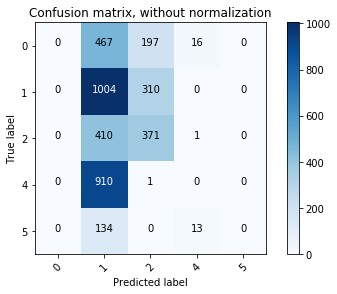

In [10]:
# Compute and plot confusion matrix
cnf_matrix = utils.confusion_matrix(Y_test_hard, Y_pred_hard)
np.set_printoptions(precision=2)

plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1,2,4,5],
                      title='Confusion matrix, without normalization')

# Section 3 - Classification with Conv2D

In [11]:
model_new2D = utils.Model2D((1,window_size,features), classes)
opt4 = Adam(lr=0.01)
model_new2D.compile(optimizer = opt4, loss = "categorical_crossentropy", metrics = ["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 5, 18)          26118     
_________________________________________________________________
batch_normalization_4 (Batch (None, 1, 5, 18)          72        
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1, 5, 18)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 3, 18)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 36)          16236     
_________________________________________________________________
batch_normalization_5 (Batch (None, 1, 1, 36)          144       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 1, 1, 36)          0         
__________

In [12]:
# need to reshape in order to fit to the new 2D model
X_train = X_train_s.reshape(X_train_s.shape[0], 1, window_size, features)
X_test = X_test_s.reshape(X_test_s.shape[0], 1, window_size, features)

model_new2D.fit(x = X_train, y = Y_train_s, epochs = 10, batch_size = 128, validation_data=(X_test, Y_test_s))

Train on 10661 samples, validate on 3834 samples
Epoch 1/10
10661/10661 [==============================] - 3s 308us/step - loss: 1.2856 - acc: 0.5310 - val_loss: 1.3398 - val_acc: 0.5587
Epoch 2/10
10661/10661 [==============================] - 2s 217us/step - loss: 0.9378 - acc: 0.6152 - val_loss: 1.7339 - val_acc: 0.3425
Epoch 3/10
10661/10661 [==============================] - 2s 212us/step - loss: 0.8893 - acc: 0.6341 - val_loss: 1.5137 - val_acc: 0.3683
Epoch 4/10
10661/10661 [==============================] - 2s 210us/step - loss: 0.8669 - acc: 0.6349 - val_loss: 1.6323 - val_acc: 0.3453
Epoch 5/10
10661/10661 [==============================] - 2s 213us/step - loss: 0.8571 - acc: 0.6426 - val_loss: 1.5570 - val_acc: 0.4726
Epoch 6/10
10661/10661 [==============================] - 2s 218us/step - loss: 0.8408 - acc: 0.6529 - val_loss: 1.5396 - val_acc: 0.3975
Epoch 7/10
10661/10661 [==============================] - 2s 221us/step - loss: 0.8351 - acc: 0.6483 - val_loss: 1.4757 - v

### Classification and evaluation of performances

C:\Users\Matteo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-measure:  0.1643373060200245
AUC w.r. to each class:  {0: 0.6347280763922563, 1: 0.8623329950955521, 2: 0.8243387003784362, 3: 0.8922129760824199, 4: 0.8969462479865827}


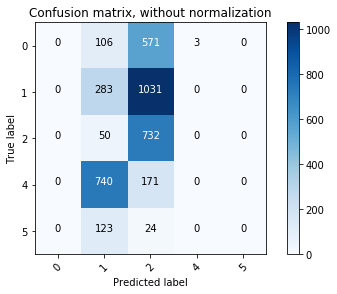

In [13]:
# predict labels
Y_pred_s = model_new2D.predict(X_test)

# print results
#reverse the one-ot encoder procedure
Y_test_hard = np.argmax(Y_test_s, axis=1)
Y_pred_hard = np.argmax(Y_pred_s, axis=1)

print("F1-measure: ", utils.f1_score(Y_test_hard, Y_pred_hard, average='weighted'))
print("AUC w.r. to each class: ", utils.AUC(Y_test_s, Y_pred_s, classes))

# Compute and plot confusion matrix
cnf_matrix = utils.confusion_matrix(Y_test_hard, Y_pred_hard)
np.set_printoptions(precision=2)

plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1,2,4,5],
                      title='Confusion matrix, without normalization')